In [1]:
from tqdm.notebook import tqdm
import torch
import datasets
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from models import unet
import torchvision
from transformers import ToTensorTransformer

## Loading the dataset and transformers

In [2]:
train_transforms = A.Compose(
        [
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ],
    )

to_tensor = ToTensorTransformer()

In [3]:
train_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc", train=True, transform=train_transforms)
validation_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc", train=False)

(512, 512, 37)


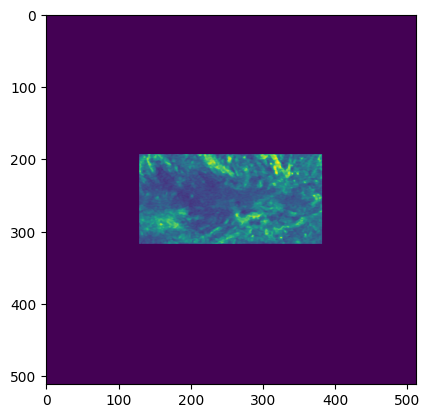

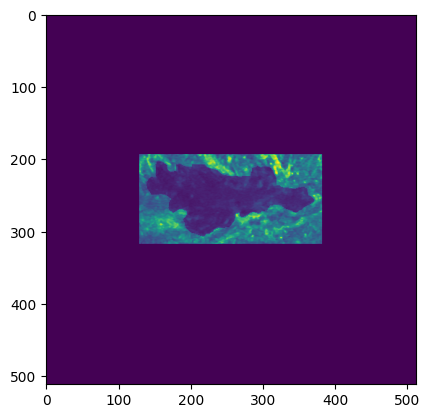

In [7]:
train_dataset.on_epoch_end()

x,y, _= train_dataset[0]
print(x.shape)
plt.imshow(x[:,:,10])
plt.show()
x = x - x*y*0.6
plt.imshow(x[:,:,10])
plt.show()

## Building the model

In [8]:
class VolumeClassifier(torch.nn.Module):
    
    def __init__(self) -> None:
        super(VolumeClassifier, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=512, hidden_size=20, num_layers=2, batch_first=True)
        self.liner = torch.nn.Linear(in_features=20, out_features=1)

    def forward(self,x):
        lstm_out, _ = self.lstm(x)
        output = self.liner(lstm_out)
        return output[-1, :]

In [6]:
m = VolumeClassifier()

x = torch.rand([128, 512])
y = m(x)
print(y.shape)

torch.Size([1])


In [8]:
class ABUSClassifier(torch.nn.Module):
    
    def __init__(self, device = "cpu"):
        super(ABUSClassifier, self).__init__()
        self.device = device
        # Base Model
        self.base_model = unet.UNet(in_channels=1, out_channels=1)
         # classification
        self.slice_classification_block = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024*16*16, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
        )
        
        self.slice_classifier = torch.nn.Linear(512, 1)
        # self.volumeClassifier = VolumeClassifier()
        # self.slices_features = torch.tensor([]).to(device)
    
    # output cls_prediction for slices, segmentation predictions and cls_prediction for volume
    def forward(self, x):
        return self.base_model(x)
      
    # knows that the volume mini-batches are finished and now it can classify then whole volume
    # def end_volume(self):
    #     ret = self.volumeClassifier(self.slices_features)
    #     self.slices_features = torch.tensor([]).to(self.device)
    #     return ret

model = ABUSClassifier()

In [9]:
x = torch.rand([10, 1, 512,512])
print(x.shape)
y = model(x)

print(y.shape)

torch.Size([10, 1, 512, 512])


/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([10, 1, 512, 512])


## Training hyperparameters

In [10]:
class DiceLoss(torch.nn.Module):
    def init(self):
        super(DiceLoss, self).init()
        
    def forward(self, pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [19]:
mini_batch_size = 1
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 10
alpha = 0.3 # how much slice classification is important for us
beta = 0.2 # how much slice segmentation is important for us
gamma = 0.5 # how much volume classification is important for us
criterion_bce = torch.nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()
model = ABUSClassifier(device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def train(model, dataset, optimizer, loss_fun_seg, loss_fun_cls):
    torch.cuda.empty_cache()

    print("training model...")
    model.train()
    loop = tqdm(dataset)
    total_slices = 0
    
    for x, y, l in loop:
        
        l = [l for i in range(x.shape[2])]
        l = np.array(l, dtype=np.float32)
        # make the tumors obviously visible
        x = x - x*y*0.3
        total_slices += x.shape[2]
        
        for i in range(0, x.shape[2], mini_batch_size):
            
            # Convert data to mini-batches
            inputs = x[:,:,i:i+mini_batch_size]
            targets = y[:,:,i:i+mini_batch_size]
            # labels = l[i:i+mini_batch_size]
            
            # Convert numpy to tensors
            inputs, targets = to_tensor((inputs, targets))
            # labels = torch.from_numpy(labels)
            # labels = labels.unsqueeze(1)
            inputs = inputs.to(device)
            targets = targets.to(device)
            # labels = labels.to(device)
                      
            # forward
            seg_predictions = model(inputs)
            seg_predictions = torch.sigmoid(seg_predictions)
            # cls_loss = loss_fn(cls_predictions, labels)
            seg_loss = loss_fun_seg(seg_predictions, targets)
            
            
            # loss = 0.8*cls_loss + 0.2*seg_loss
            
            # backward
            optimizer.zero_grad()
            seg_loss.backward()
            optimizer.step()
                
            # with torch.no_grad():
            #     cls_preds = torch.sigmoid(cls_predictions)
            #     cls_preds = (cls_preds > 0.5)
            #     num_corrects += (cls_preds == labels).sum()
            
            loop.set_postfix(loss=seg_loss.item())

            # Empty gpu memory
            inputs = None
            targets = None
            seg_loss = None
            torch.cuda.empty_cache()
        
        # Here we have to do the vol classification task
        # prediction = model.end_volume().unsqueeze(0)
        # label = torch.tensor([l[0]]).to(device).unsqueeze(0)
        # vol_cls_loss = loss_fn(prediction, label)
        
        # with torch.no_grad():
        #     vol_pred = torch.sigmoid(prediction)
        #     vol_pred = (vol_pred > 0.5)
        #     num_volume_corrects = (prediction == label).sum()
            
            # Total loss is calculated as below


# train(model, train_dataset, optimizer, criterion)

In [10]:
def calculate_accuracy(dataset, model, device="cuda"):
    
    print("calculating model accuracy...")
    num_correct_pixels = 0
    num_correct_slices = 0
    num_slices = 0
    num_pixels = 0
    dice_score = 0
    
    model.eval()
    loop = tqdm(dataset)

    with torch.no_grad():
        for data in loop:
            x, y, l = data
            l = [l for i in range(x.shape[2])]
            l = np.array(l, dtype=np.float32)
            # make the tumors obviously visible
            x = x - x*y*0.3
            num_slices += x.shape[2]
            depth = x.shape[2]
            for i in range(0, depth, mini_batch_size):
                # Convert data to mini-volumes to be compatible with the gpu memory
                inputs = x[:,:,i:i+mini_batch_size]
                targets = y[:,:,i:i+mini_batch_size]
                labels = l[i:i+mini_batch_size]
                
                # Convert numpy to tensors
                inputs, targets = to_tensor((inputs, targets))
                labels = torch.from_numpy(labels)
                labels = labels.unsqueeze(1)
                inputs = inputs.to(device)
                targets = targets.to(device)
                labels = labels.to(device)
                        
                # forward
                seg_predictions, cls_predictions, cls_features = model(inputs)
                seg_predictions = (torch.sigmoid(seg_predictions) > 0.5).float()
                cls_predictions = (torch.sigmoid(cls_predictions) > 0.5).float()
                num_correct_pixels += (seg_predictions == targets).sum()
                num_correct_slices += (cls_predictions == labels).sum()
                num_pixels += torch.numel(cls_predictions)
                dice_score += ( 2 * (seg_predictions * targets).sum())/((seg_predictions + targets).sum()+1e-8)
                # Calculate volume classification accuracy
                # To be done
                torch.cuda.empty_cache()

            
            loop.set_postfix( slice_accuracy=(num_correct_slices/num_slices).item(), dice_score=dice_score.item(), segmentation_acc=(num_correct_pixels/num_pixels).item())
    
    model.train()
    
calculate_accuracy(validation_dataset, model)

calculating model accuracy...


  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
def save_results_as_imgs(model, dataset, path="./saved_images"):
    
    torch.cuda.empty_cache()
    print("Saving the results as images...")
    model.eval()
    idx = 2
    vol, mask, label = dataset[idx]
    vol = vol - vol*mask*0.3
    vol = vol[:,:,4:6]
    mask = mask[:,:,4:6]
    vol, mask = to_tensor((vol, mask))
    vol = vol.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        segmentation_preds  = model(vol)
        segmentation_preds = torch.sigmoid(segmentation_preds)
        segmentation_preds = (segmentation_preds > 0.5).float()
        torchvision.utils.save_image(segmentation_preds, f"{path}/prediction.png")
        torchvision.utils.save_image(mask, f"{path}/ground_truth.png")
    
    torch.cuda.empty_cache()
    model.train()
    
save_results_as_imgs(model, validation_dataset)

Saving the results as images...


In [22]:
torch.cuda.empty_cache()


In [23]:
for i in range(num_epochs):
    train(model, train_dataset, optimizer, criterion_dice, criterion_bce)
    # calculate_accuracy(validation_dataset, model)
    save_results_as_imgs(model, validation_dataset)
    # Shuffle the datasets
    train_dataset.on_epoch_end()
    validation_dataset.on_epoch_end()


training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

Saving the results as images...
training model...


  0%|          | 0/80 [00:00<?, ?it/s]

In [13]:
model.eval()

x, y, l = validation_dataset[4]

x = x[:,:,6:12]
y = y[:,:,6:12]

print(l)

print(x.shape)

x, y = to_tensor((x,y))
x = x.to(device)
print(x.shape)
seg_pred, cls_pred, features = model(x)
prediction = torch.sigmoid(cls_pred)
prediction = (prediction > 0.5).float()
print(prediction)


model.train()

1
(256, 256, 6)
torch.Size([6, 1, 256, 256])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


ABUSClassifier(
  (base_model): UNet(
    (slice_classifier): Linear(in_features=512, out_features=1, bias=True)
    (encoder): ModuleList(
      (0): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin